<center><font size=5>pandas ta因子选择</font></center>

目前只有IC相关的计算。余下的有待大家探索。

加载各种包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('..')  # 文件位于

import factors  # 因子计算
import data_utils  # 数据读取
import performance as perf  # IC计算
import plotting  #绘图

# 1. 初始化DataLoader 

DataLoader实现了对csv文件的批量读取，会按照\[年\]\[月\]保存在dl中。
一些重要函数：
- init_month_df: 加载目标文件夹下的所有zip文件。这些文件读取后会被保存在dataloader中。注意，

In [2]:
dl = data_utils.DataLoader()
dl.init_month_df('E:/jupyternote/QF/CryptalC/data/UDST_M/15m_data')
# 计算未来收益率
data_utils.compute_future_rtn_for_all(dl)

# 2. 计算因子
ta Core indicators
测试批量生成因子

In [3]:
import pandas_ta as ta
import pandas as pd
from tqdm import tqdm
import time

e = pd.DataFrame()
core_indicators = e.ta.indicators(as_list=True)  # 获取所有indicators列表

### indicators函数有效性的检验
1. 计算不能报错
2. 计算时间不能太长

In [4]:
test_df = dl.get_month_df('2020','01')[3].copy()  # 用于测试函数

In [5]:
def preprocess(df):
    df.drop('volume', axis=1, inplace=True)
    df.rename({'quote_volume':'volume'},axis=1, inplace=True)
#     df['volume'] = np.log(df['volume'] + 1)
    return df

In [6]:
# test_df = preprocess(test_df)
# 遍历判断哪些是直接可用的
remove_fun_list = []  # 不需要计算的func
time_list = []  # 保存函数计算的时长
for indicator_name in tqdm(core_indicators):
    try:
        fun = getattr(test_df.ta, indicator_name)
        # 记录代码开始时间
        start_time = time.time()
        for i in range(1):
            temp_data = fun(append=True)
        # 记录代码结束时间
        end_time = time.time()
        # 计算代码执行时间
        execution_time = end_time - start_time
        if type(temp_data) == pd.core.frame.DataFrame and 'open_time' in temp_data.columns:
            remove_fun_list.append(indicator_name)
            time_list.append(999)
        else:
            time_list.append(execution_time)
    except:
        remove_fun_list.append(indicator_name)
        time_list.append(999)

  6%|████▌                                                                             | 8/143 [00:00<00:02, 61.01it/s]

[X] Ooops!!! It's True, the series 'b' was not found in open_time, open, high, low, close, volume, close_time, quote_volume, count, taker_buy_volume, taker_buy_quote_volume, ignore, fwd_rtn_5, fwd_rtn_5_real, fwd_rtn_5_bool, fwd_rtn_5_abs, fwd_rtn_10, fwd_rtn_10_real, fwd_rtn_10_bool, fwd_rtn_10_abs, fwd_rtn_20, fwd_rtn_20_real, fwd_rtn_20_bool, fwd_rtn_20_abs, fwd_rtn_50, fwd_rtn_50_real, fwd_rtn_50_bool, fwd_rtn_50_abs, fwd_rtn_1, fwd_rtn_1_real, fwd_rtn_1_bool, ABER_ZG_5_15, ABER_SG_5_15, ABER_XG_5_15, ABER_ATR_5_15
[X] value is not a number
[X] value is not a number


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:03<00:00, 40.50it/s]

[!] VWAP volume series is not datetime ordered. Results may not be as expected.
[!] VWAP price series is not datetime ordered. Results may not be as expected.


In [7]:
time_df = pd.DataFrame({
    'factor': core_indicators,
    'time':time_list
})

In [8]:
time_df.shape

(143, 2)

In [9]:
time_df.sort_values('time').tail(10)

,factor,time
93,qqe,0.377478
118,td_seq,1.485721
67,long_run,999.000000
135,vwap,999.000000
16,below_value,999.000000
102,short_run,999.000000
2,above_value,999.000000
1,above,999.000000
140,xsignals,999.000000
126,tsignals,999.000000


In [10]:
valid_core_indicators = list(time_df.sort_values('time')['factor'].values[:100])

### 因子层面：简单判断有效性
1. nan值
2. mean值
3. 粗略估计IC

In [11]:
test_df = dl.get_month_df('2021','10')[0].copy()  # 用于测试函数
test_df = preprocess(test_df)
# 遍历判断哪些是直接可用的
current_factor_names = []  # 保存因子名称
indicators = []
for indicator_name in tqdm(valid_core_indicators):
    fun = getattr(test_df.ta, indicator_name)
    temp_data = fun(append=True)
    temp_factor_names = []
    if type(temp_data) == pd.core.series.Series:
        temp_factor_names = [temp_data.name]
    elif type(temp_data) == tuple:
        temp_factor_names = list(temp_data[0].columns)
    else:
        temp_factor_names = list(temp_data.columns)
    
    for _ in temp_factor_names:
        indicators.append(indicator_name)
    
    current_factor_names +=  temp_factor_names

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 723.75it/s]


In [12]:
# 构造一个df，用于特征名称和func之间的对应关系
func2factor_df = pd.DataFrame({
    'funcName':indicators,
    'factorName':current_factor_names,
})

### 清理明显不合适的特征

In [13]:
import cufflinks

In [14]:
factors_df = test_df[current_factor_names]

In [15]:
remove_cols = []
remove_cols += list(factors_df.columns[factors_df.isna().sum() > 200])  # nan值太多所以清理掉
remove_cols += list(factors_df.columns[factors_df.mean() > 100000])  # 均值过大所以清理掉
# 找到那些没有使用未来数据的因子: 最后一行必须有数值
invalid_cols = factors_df.columns[factors_df.isna().iloc[-1,:].values]
remove_cols += list(invalid_cols)

## 2. 构造cleaned factors函数

In [16]:
cleaned_factors = set(current_factor_names) - set(remove_cols)

In [17]:
len(current_factor_names)

144

In [18]:
len(cleaned_factors)

133

In [19]:
@factors.handle_dataloader_data
def add_core_factors(raw_df:pd.DataFrame, core_indicators)-> pd.DataFrame:
    '''
    加入新因子的模板。
    :param raw_df: 原始数据
    :param core_indicators: 因子名称
    :return: 原始数据+因子
    '''
    raw_df = preprocess(raw_df)
    for indicator_name in valid_core_indicators:
        fun = getattr(raw_df.ta, indicator_name)
        temp_data = fun(append=True)
    return raw_df

In [20]:
# 计算因子
add_core_factors(dl, core_indicators)

year: 2020


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.18s/it]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:54<00:00,  9.53s/it]


year: 2022


 33%|███████████████████████████▋                                                       | 4/12 [00:48<01:33, 11.70s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10

 42%|██████████████████████████████████▌                                                | 5/12 [01:00<01:23, 11.93s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10

 50%|█████████████████████████████████████████▌                                         | 6/12 [01:12<01:10, 11.83s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2022, month:07, i:33


 58%|████████████████████████████████████████████████▍                                  | 7/12 [01:27<01:03, 12.74s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2022, month:08, i:33


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [02:16<00:30, 15.36s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10

 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [02:33<00:16, 16.15s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2022, month:12, i:31


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:55<00:00, 14.65s/it]


year: 2023


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:01, i:32


  8%|██████▉                                                                            | 1/12 [00:24<04:34, 24.95s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:02, i:33


 17%|█████████████▊                                                                     | 2/12 [00:38<03:05, 18.53s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:03, i:34


 25%|████████████████████▊                                                              | 3/12 [00:56<02:42, 18.01s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:04, i:34


 33%|███████████████████████████▋                                                       | 4/12 [01:12<02:19, 17.41s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:05, i:35


 42%|██████████████████████████████████▌                                                | 5/12 [01:35<02:14, 19.23s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:06, i:36


 50%|█████████████████████████████████████████▌                                         | 6/12 [01:55<01:57, 19.54s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:07, i:36


 58%|████████████████████████████████████████████████▍                                  | 7/12 [02:22<01:49, 21.95s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:08, i:40


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [02:59<01:46, 26.65s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:09, i:42


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [03:25<01:19, 26.62s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



Exception: inputs are all NaN
Error: year: 2023, month:10, i:43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:01<00:00, 20.10s/it]


# 3.查看因子IC

In [21]:
for colname in tqdm(cleaned_factors):
#     print(f'feat name: {colname}')
    tests_factor_name = colname
    # 计算因子IC
    month_mean_ic = perf.cal_monthly_mean_ic(dl, factor_name=tests_factor_name, use_real_rtn=True)
    # 保存记录
    dl.set_record_df(kind='Info', factor_name=tests_factor_name, result_df=month_mean_ic)
    # 读取记录，并且展示作图
#     month_mean_ic = dl.get_record_df(kind='Info', factor_name=tests_factor_name)
#     plotting.plot_information_table(month_mean_ic)

 14%|███████████▎                                                                   | 19/133 [19:50<1:34:27, 49.72s/it]F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [1:53:56<00:00, 51.40s/it]


总结，并且整理一下每个因子的平均iC

## 分别统计 mean ic 和 adjusted ic

In [22]:
record_mean_ic = []
record_adjustd_ic = []
for factor_name in cleaned_factors:
    temp_month_ic = dl.get_record_df(kind='Info', factor_name=factor_name).copy()
    # 分别计算mean ic 和 adjusted ic
    mean_IC_Series = temp_month_ic.mean()
    mean_IC_Series.name = factor_name    

    std_Series = temp_month_ic.std()
    adjusted_IC_Series = mean_IC_Series / std_Series
    adjusted_IC_Series.name = factor_name     
    
    record_mean_ic.append(mean_IC_Series)
    record_adjustd_ic.append(adjusted_IC_Series)



In [23]:
mean_IC_df = pd.concat(record_mean_ic, axis=1).T
adjusted_IC_df = pd.concat(record_adjustd_ic, axis=1).T

In [24]:
mean_IC_df.isna().sum()

fwd_rtn_1_real     1
fwd_rtn_5_real     1
fwd_rtn_10_real    1
fwd_rtn_20_real    1
fwd_rtn_50_real    1
fwd_rtn_10_abs     1
dtype: int64

In [28]:
drop_list = ['EOM_14_100000000']

In [29]:
mean_IC_df.drop(drop_list, inplace=True)
adjusted_IC_df.drop(drop_list, inplace=True)
mean_IC_df.dropna(inplace=True)
adjusted_IC_df.dropna(inplace=True)

### 观察IC和IR的分布

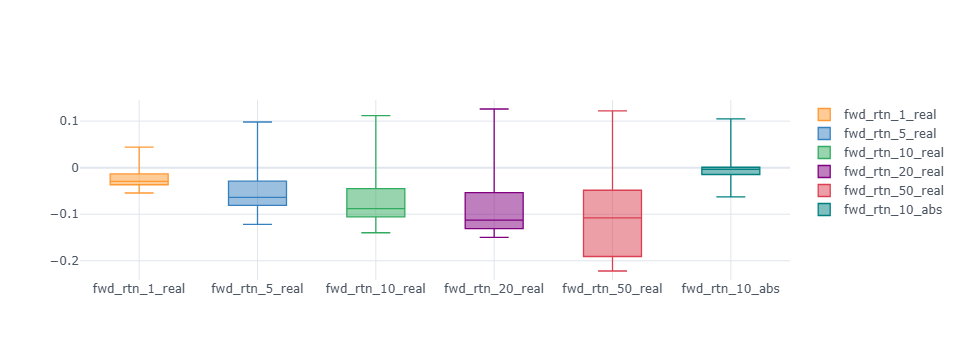

In [30]:
mean_IC_df.iplot('box')

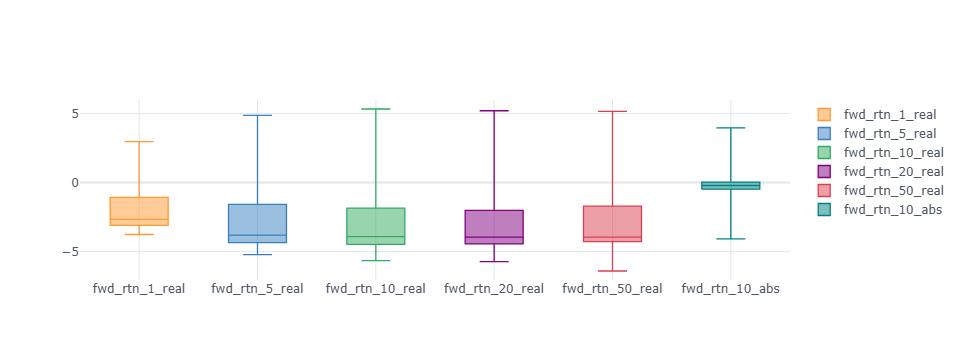

In [31]:
adjusted_IC_df.iplot('box')

In [32]:
def get_indices_by_percentile(df, target_col, upper_p=80, lower_p=20):
    '''
    取出一个df中对应列满足条件的索引。默认首尾20%。
    '''
    upper = np.percentile(df[target_col],upper_p)
    lower = np.percentile(df[target_col],lower_p)
    high_value_indices = df[np.logical_or(df[target_col] > upper, df[target_col] < lower)].index
    
    return list(high_value_indices)

In [33]:
np.percentile(mean_IC_df['fwd_rtn_20_real'],50)

-0.11281913784398379

In [34]:
np.percentile(mean_IC_df['fwd_rtn_20_real'],97)

0.08904186374093563

In [35]:
np.percentile(mean_IC_df['fwd_rtn_10_abs'],95)

0.04281539294575931

In [36]:
all_valid_factors = list(mean_IC_df.index)
high_ic_factors = get_indices_by_percentile(mean_IC_df, 'fwd_rtn_20_real', 96, 10)
high_abs_ic_factors = list(set(high_ic_factors + get_indices_by_percentile(mean_IC_df, 'fwd_rtn_10_abs', 95, 0)))
high_ic_factor_60 = get_indices_by_percentile(mean_IC_df, 'fwd_rtn_20_real', 96, 60)
high_ic_factor_40 = get_indices_by_percentile(mean_IC_df, 'fwd_rtn_20_real', 96, 40)
high_ic_factor_20 = get_indices_by_percentile(mean_IC_df, 'fwd_rtn_20_real', 96, 20)

print(f'all: {len(all_valid_factors)}')
print(f'high_ic: {len(high_ic_factors)}')
print(f'high_abs: {len(high_abs_ic_factors)}')
print(f'high_ic_factor_60: {len(high_ic_factor_60)}')
print(f'high_ic_factor_40: {len(high_ic_factor_40)}')
print(f'high_ic_factor_20: {len(high_ic_factor_20)}')

all: 131
high_ic: 19
high_abs: 26
high_ic_factor_60: 84
high_ic_factor_40: 58
high_ic_factor_20: 32


# 4. 观察ml 效果 

准备一下Z_score

In [37]:
def cal_Z_score(factor_df, column_lists, span):
    '''Z-score'''
    for column_name in column_lists:
        mean_20 = factor_df[column_name].ewm(span, adjust=False).mean()
        std_20 = factor_df[column_name].ewm(96, adjust=False).std()  # todo 超参数搜索
        factor_df[f'{column_name}_Z'] = (factor_df[column_name].values - mean_20) / std_20
    return factor_df

@factors.handle_dataloader_data
def add_close_Z(raw_df:pd.DataFrame)-> pd.DataFrame:
    raw_df = cal_Z_score(raw_df, ['close'], 30)
    return raw_df

@factors.handle_dataloader_data
def add_base_factors(raw_df:pd.DataFrame)-> pd.DataFrame:
    '''
    加入新因子的模板。
    :param raw_df: 原始数据
    :param factor_name: 因子名称
    :return: 原始数据+因子
    '''
    raw_df['macd'] = raw_df.ta.macd()['MACD_12_26_9']
    raw_df['rsi'] = raw_df.ta.rsi()    
    return raw_df

In [59]:
add_base_factors(dl)

year: 2020


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.63it/s]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.18it/s]


year: 2022


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.11it/s]


year: 2023


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.64it/s]


In [38]:
add_close_Z(dl)

year: 2020


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.04it/s]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.07it/s]


year: 2022


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.84it/s]


year: 2023


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


In [39]:
from ml_performance import MLFactorEvaluator

## 一定要注意未来数据，比如centered=True

In [72]:
record_names = ['baseline'] + all_valid_factors[:10]

In [73]:
factor_names = [
        ['macd', 'rsi'],
] + [[x] for x in all_valid_factors[:10]]

In [62]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [75]:
best_params = {
    'max_depth': 4,
    'n_estimators': 50,
    'n_jobs': 4,
    'reg_lambda': 10,
    'subsample': 0.5,
    'gamma': 5
}

In [76]:
ml_evaluator = MLFactorEvaluator(
    method = XGBClassifier, 
    record_names = record_names, 
    factor_names = factor_names,
    params_dict = best_params
)

In [77]:
ml_evaluator.evaluate(dl, 'fwd_rtn_20_bool')

 10%|████████▎                                                                          | 1/10 [00:55<08:21, 55.76s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\naesar\AppData\Local\Temp/ipykernel_12076/1882701393.py", line 1, in <module>
    ml_evaluator.evaluate(dl, 'fwd_rtn_20_bool')
  File "..\ml_performance.py", line 44, in evaluate
    test_df = self.get_data(dataloader, test_ind)
  File "..\ml_performance.py", line 82, in get_data
    data_df = pd.concat(df_list, axis=0)
  File "F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\util\_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\reshape\concat.py", line 307, in concat
    return op.get_result()
  File "F:\ProgramData\Anaconda3\envs\pythonlab\lib\site-packages\pandas\core\reshape\concat.py", line 532, in get_result
    new_data = concatenate_manag

TypeError: object of type 'NoneType' has no len()

In [66]:
ml_record = ml_evaluator.get_assess_df('f1')

In [67]:
plotting.plot_ML_table(ml_record)

Machine Learning records


,0,1,2,3,4,5,6,7,8,9,mean,std
baseline,0.6135,0.6072,0.6028,0.6311,0.6191,0.6246,0.6046,0.6473,0.6185,0.6074,0.6176,0.0139
high_ic,0.6027,0.5745,0.5883,0.5807,0.5765,0.5990,0.5734,0.6275,0.6106,0.5766,0.5910,0.0184


Machine Learning T-test Analysis


,t_ind,p_ind,t_rel,p_rel
record_name,,,,
high_ic,3.6631,0.0018,6.1492,0.0002


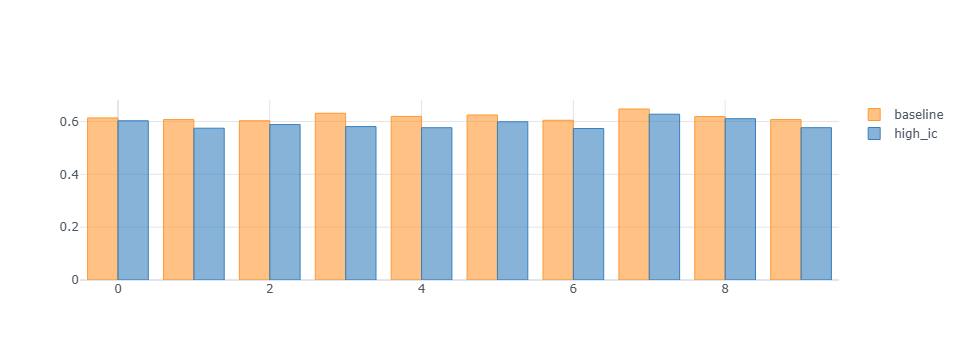

In [68]:
plotting.plot_ML_records(ml_record)

### t test

## 获取最佳特征和最佳ta functions

In [52]:
len(high_ic_factors)

19

In [53]:
best_funcs = func2factor_df[func2factor_df['factorName'].isin(high_ic_factors)]

In [54]:
best_funcs.reset_index(inplace=True, drop=True)

In [55]:
funcName = list(best_funcs.funcName.values)
factorName = list(best_funcs.factorName.values)

In [56]:
best_funcs

,funcName,factorName
0,zscore,ZS_30
1,dema,DEMA_10
2,hl2,HL2
3,midprice,MIDPRICE_2
4,bias,BIAS_SMA_26
5,wcp,WCP
6,midpoint,MIDPOINT_2
7,ui,UI_14
8,ohlc4,OHLC4
9,dm,DMN_14


In [57]:
print(funcName)

['zscore', 'dema', 'hl2', 'midprice', 'bias', 'wcp', 'midpoint', 'ui', 'ohlc4', 'dm', 'aroon', 'hlc3', 'zlma', 'decreasing', 'decay', 'tema', 'cdl_z', 'vortex', 'amat', 'adx']


In [58]:
print(factorName)

['ZS_30', 'DEMA_10', 'HL2', 'MIDPRICE_2', 'BIAS_SMA_26', 'WCP', 'MIDPOINT_2', 'UI_14', 'OHLC4', 'DMN_14', 'AROOND_14', 'HLC3', 'ZL_EMA_10', 'DEC_1', 'LDECAY_5', 'TEMA_10', 'close_Z_30_1', 'VTXM_14', 'AMATe_SR_8_21_2', 'DMN_14']
